In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

print(os.getcwd())

C:\Users\rusla\Desktop\ITMO\7-sem\thesis\rhtr\src\segmentation\visualization


In [4]:
# make project root directory the working directory
os.chdir('C:/Users/rusla/Desktop/ITMO/7-sem/thesis/rhtr')
print(os.getcwd())

C:\Users\rusla\Desktop\ITMO\7-sem\thesis\rhtr


In [33]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pyclipper
from shapely.geometry import Polygon
from PIL import Image

%matplotlib inline

dataset_filepath = 'data/raw/school_notebooks_RU'

with open(f'{dataset_filepath}/annotations_test.json', 'r') as file:
    annotations = json.load(file)

category_id2name = {category['id']: category['name'] for category in annotations['categories']}
image_id2file = {image['id']: image['file_name'] for image in annotations['images']}

def add_mask(i, segmentation, shrink_ratio, color):
    poly = Polygon(segmentation)
    pco = pyclipper.PyclipperOffset()
    pco.AddPath(segmentation, pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
    
    distance = int(poly.area * (1 - shrink_ratio ** 2) / poly.length)
    # polygon may split into several parts after shrink operation
    # https://stackoverflow.com/a/33902816
    shrinked_bboxes = pco.Execute(-distance)
    for shrinked_bbox in shrinked_bboxes:
        shrinked_bbox = np.array(shrinked_bbox)
        cv2.fillPoly(i, [shrinked_bbox], color)
        
    return i

iid = 20
image = cv2.imread(f'{dataset_filepath}/images/{image_id2file[iid]}')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for idx, annotation in enumerate(annotations['annotations']):    
    image_id = annotation['image_id']
    image_file = image_id2file[image_id]
    category = category_id2name[annotation['category_id']]
    
    if category not in ['pupil_text', 'pupil_comment', 'teacher_comment']: continue
    if image_id != iid: continue

    segmentation = annotation['segmentation']
    segmentation = np.array(segmentation).reshape(-1, 2).astype(np.int32)
    # print(f'{image_file=}, {category=}, {segmentation=}')

    n = 10
    from matplotlib.pyplot import cm
    color = cm.rainbow(np.linspace(0, 1, n))
    for i in reversed(range(1, n)):
        # color = np.random.randint(0, 255, size=(3,))
        #convert data types int64 to int
        c = (int(color[i][0] * 255), int(color[i][1] * 255), int(color[i][2] * 255))
        image = add_mask(image, segmentation, i / 10, c)
    
im = Image.fromarray(image)
im.save(f'data/processed/test_mask_0.png')

image_path='data/raw/school_notebooks_RU/images_processed\\2013.jpg' target_path='data/raw/school_notebooks_RU/targets\\2013.npy'
layers count: 5
layer 0 - color (127, 0, 255)
layer 1 - color (25, 149, 242)
layer 2 - color (76, 242, 206)
layer 3 - color (178, 242, 149)


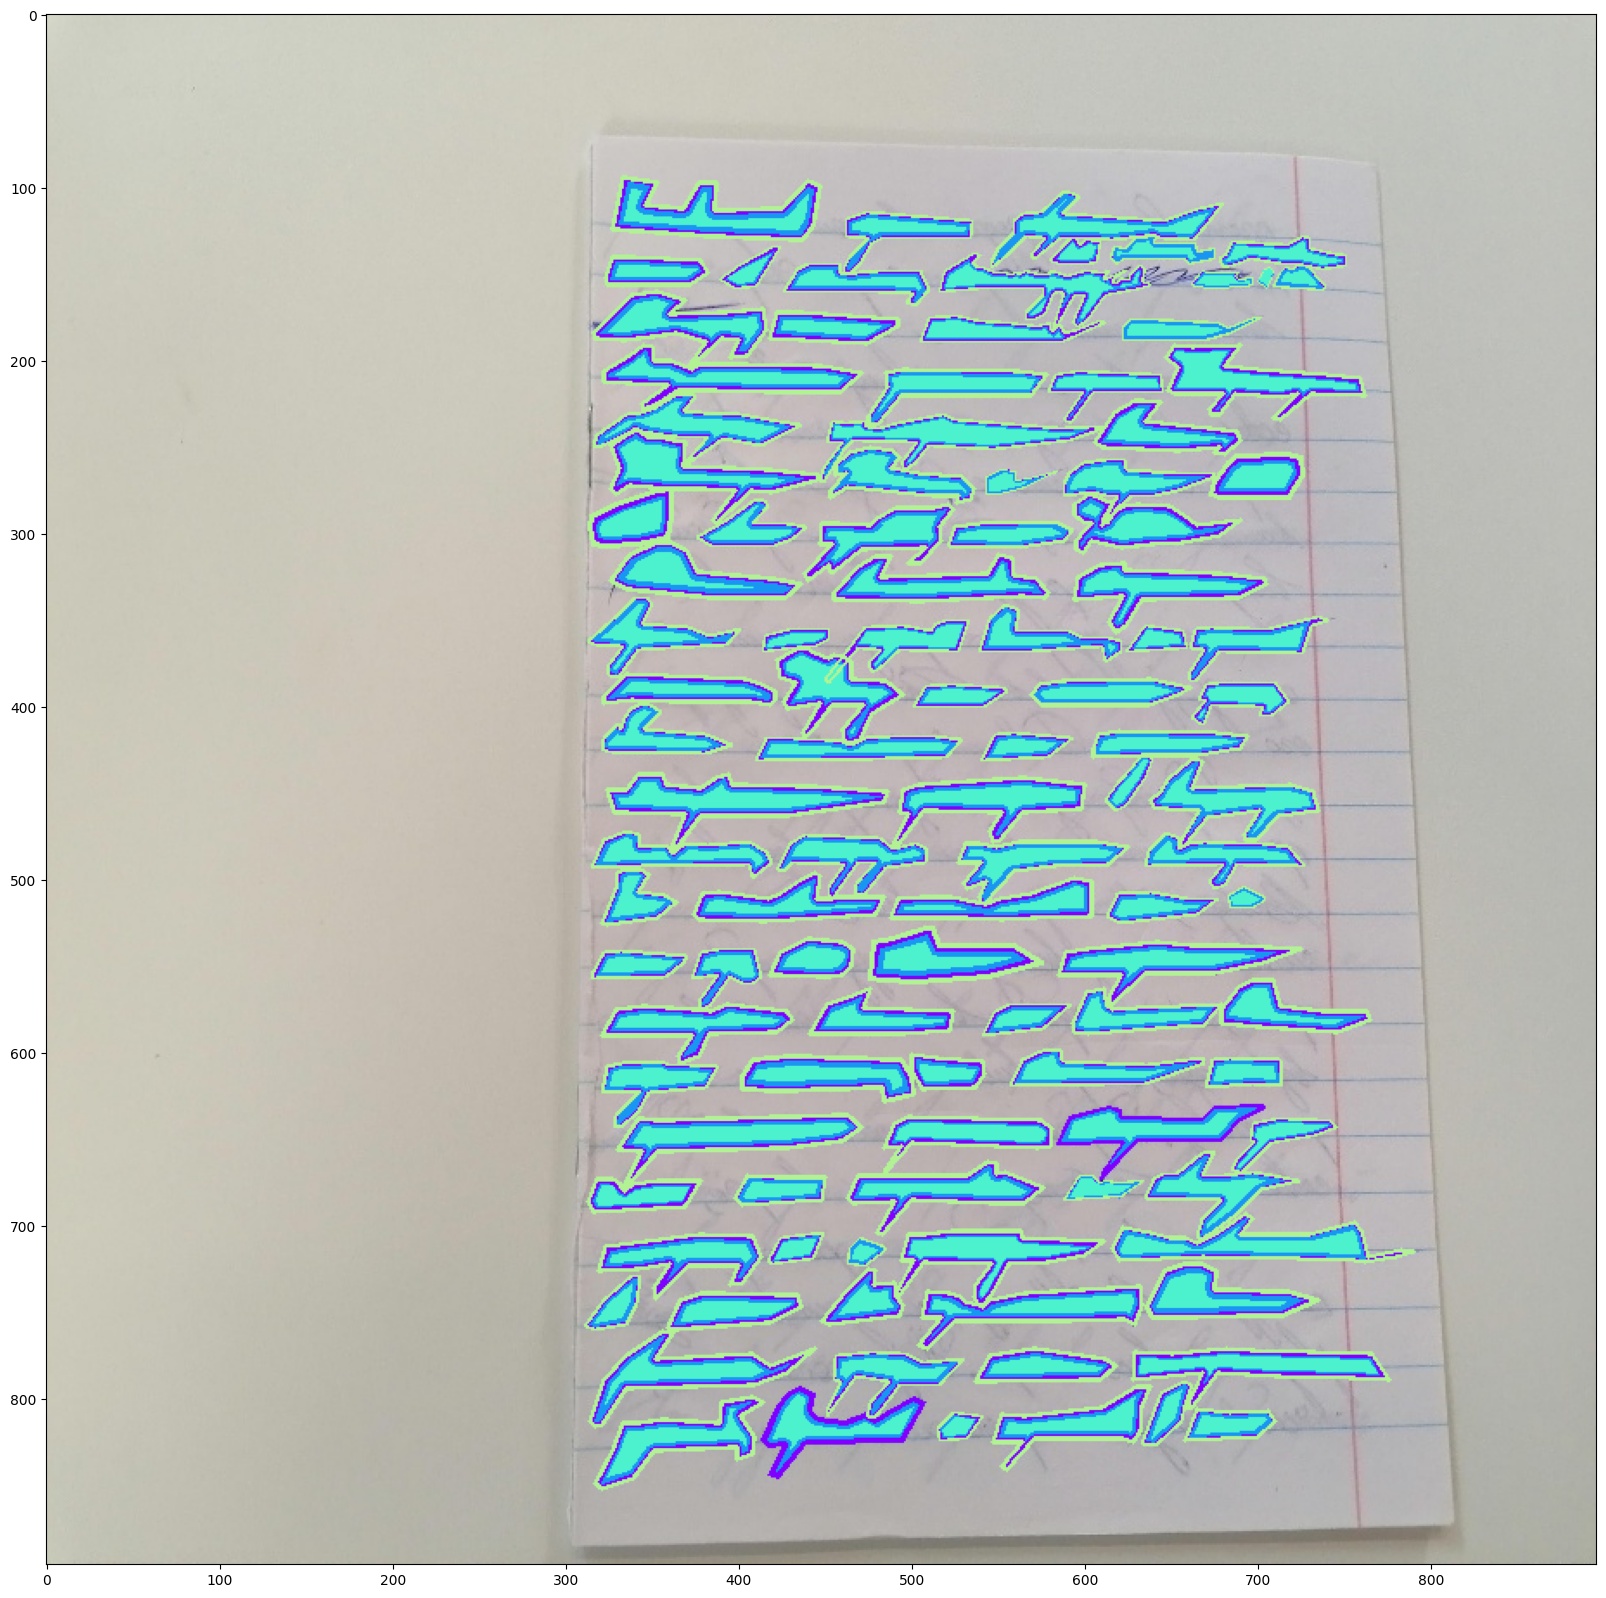

image_path='data/raw/school_notebooks_RU/images_processed\\2014.jpg' target_path='data/raw/school_notebooks_RU/targets\\2014.npy'
layers count: 5
layer 0 - color (127, 0, 255)
layer 1 - color (25, 149, 242)
layer 2 - color (76, 242, 206)
layer 3 - color (178, 242, 149)


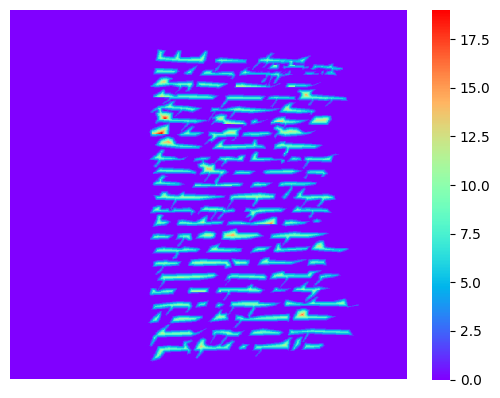

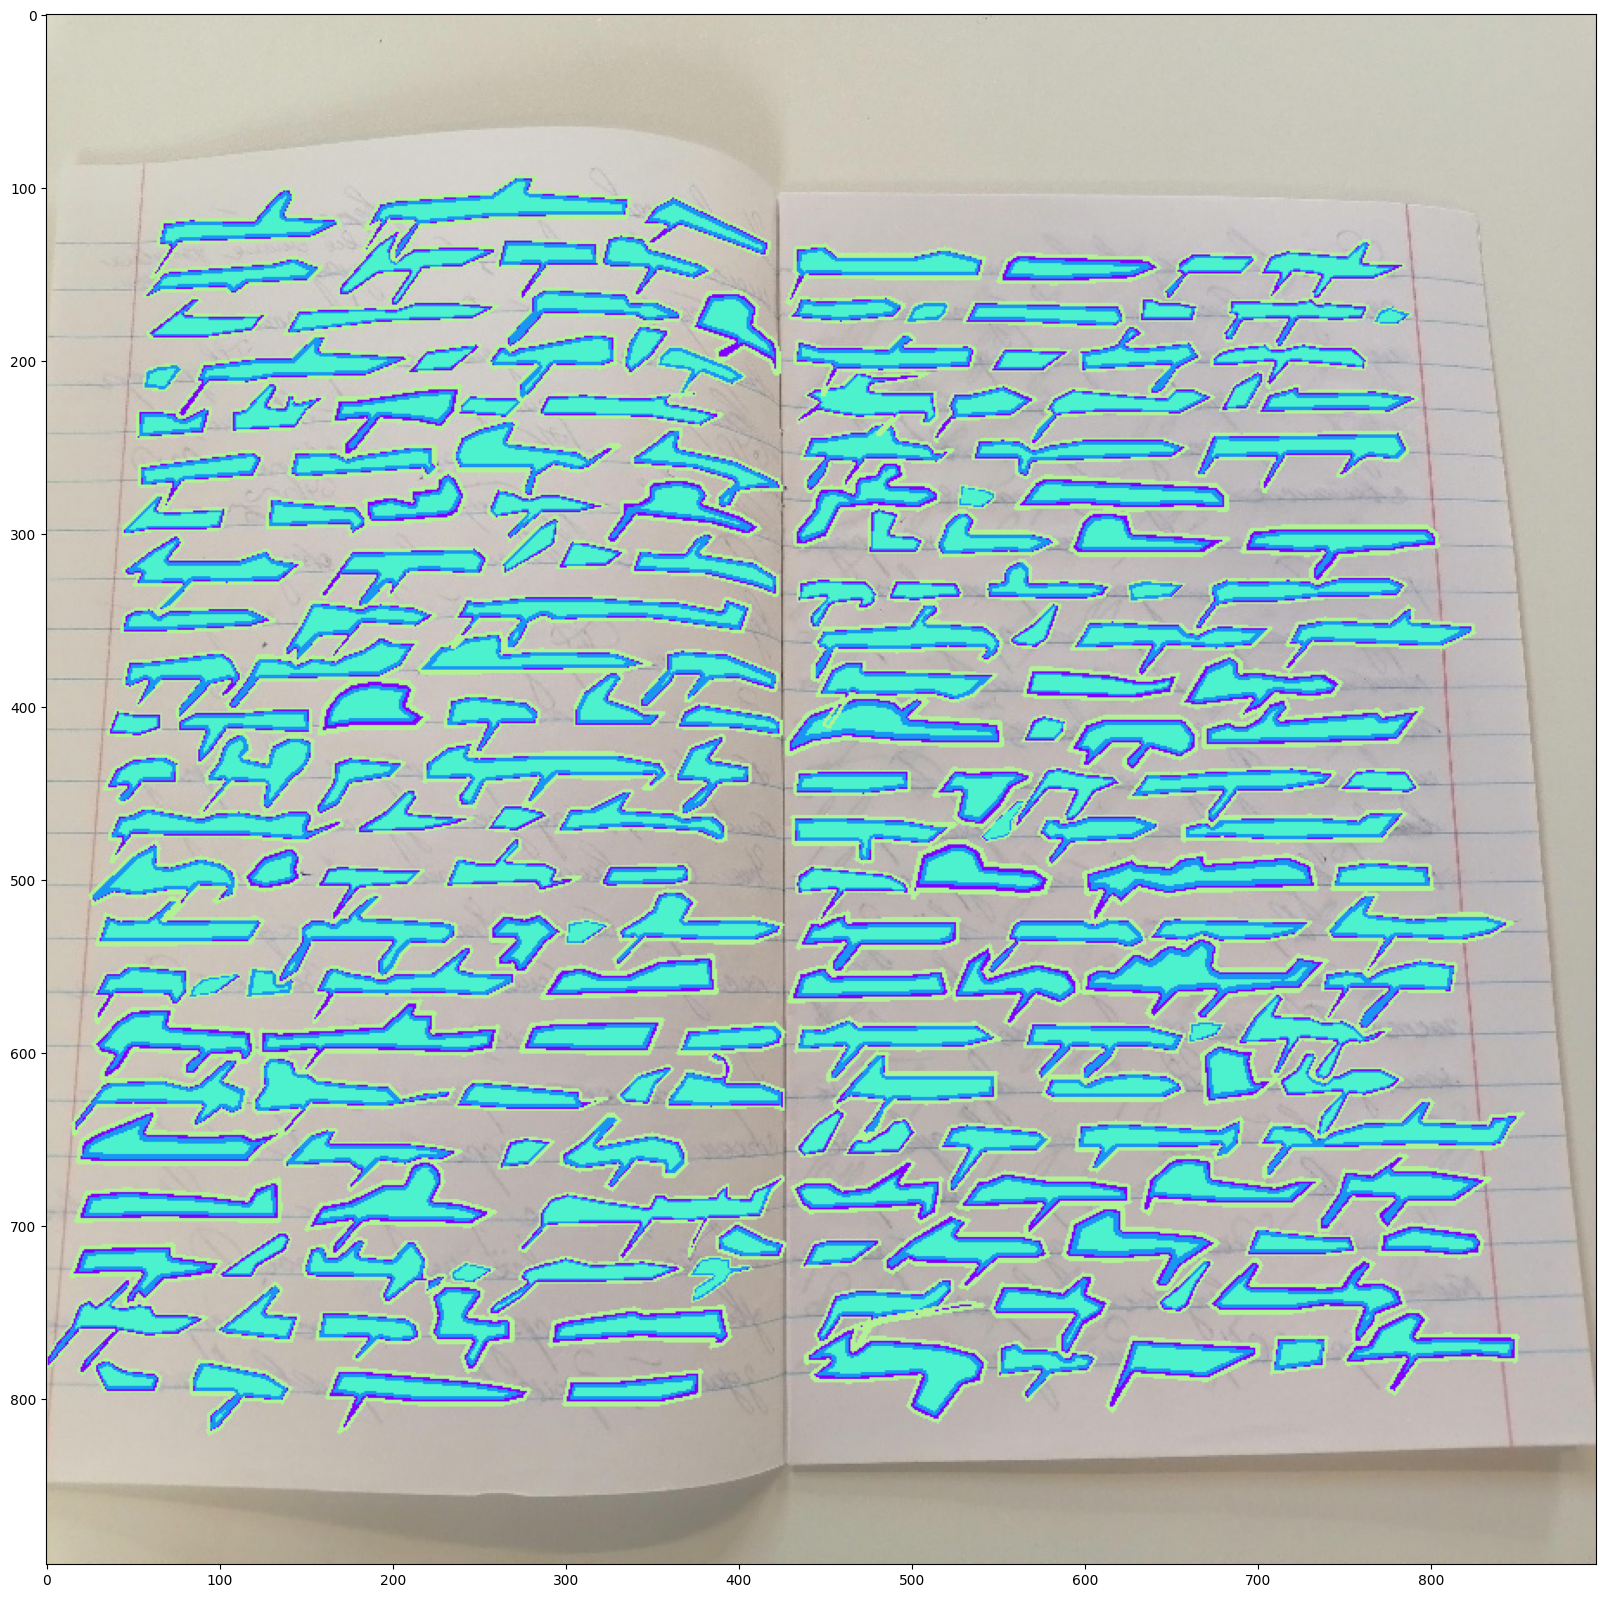

image_path='data/raw/school_notebooks_RU/images_processed\\2015.jpg' target_path='data/raw/school_notebooks_RU/targets\\2015.npy'
layers count: 5
layer 0 - color (127, 0, 255)
layer 1 - color (25, 149, 242)
layer 2 - color (76, 242, 206)
layer 3 - color (178, 242, 149)


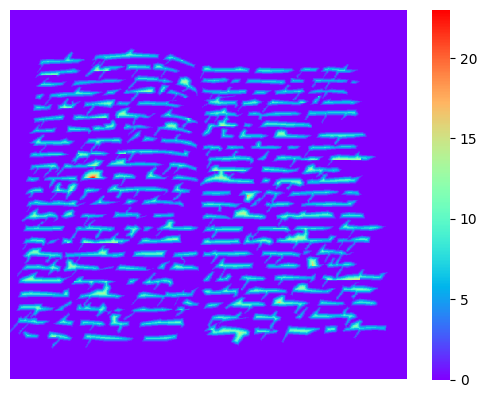

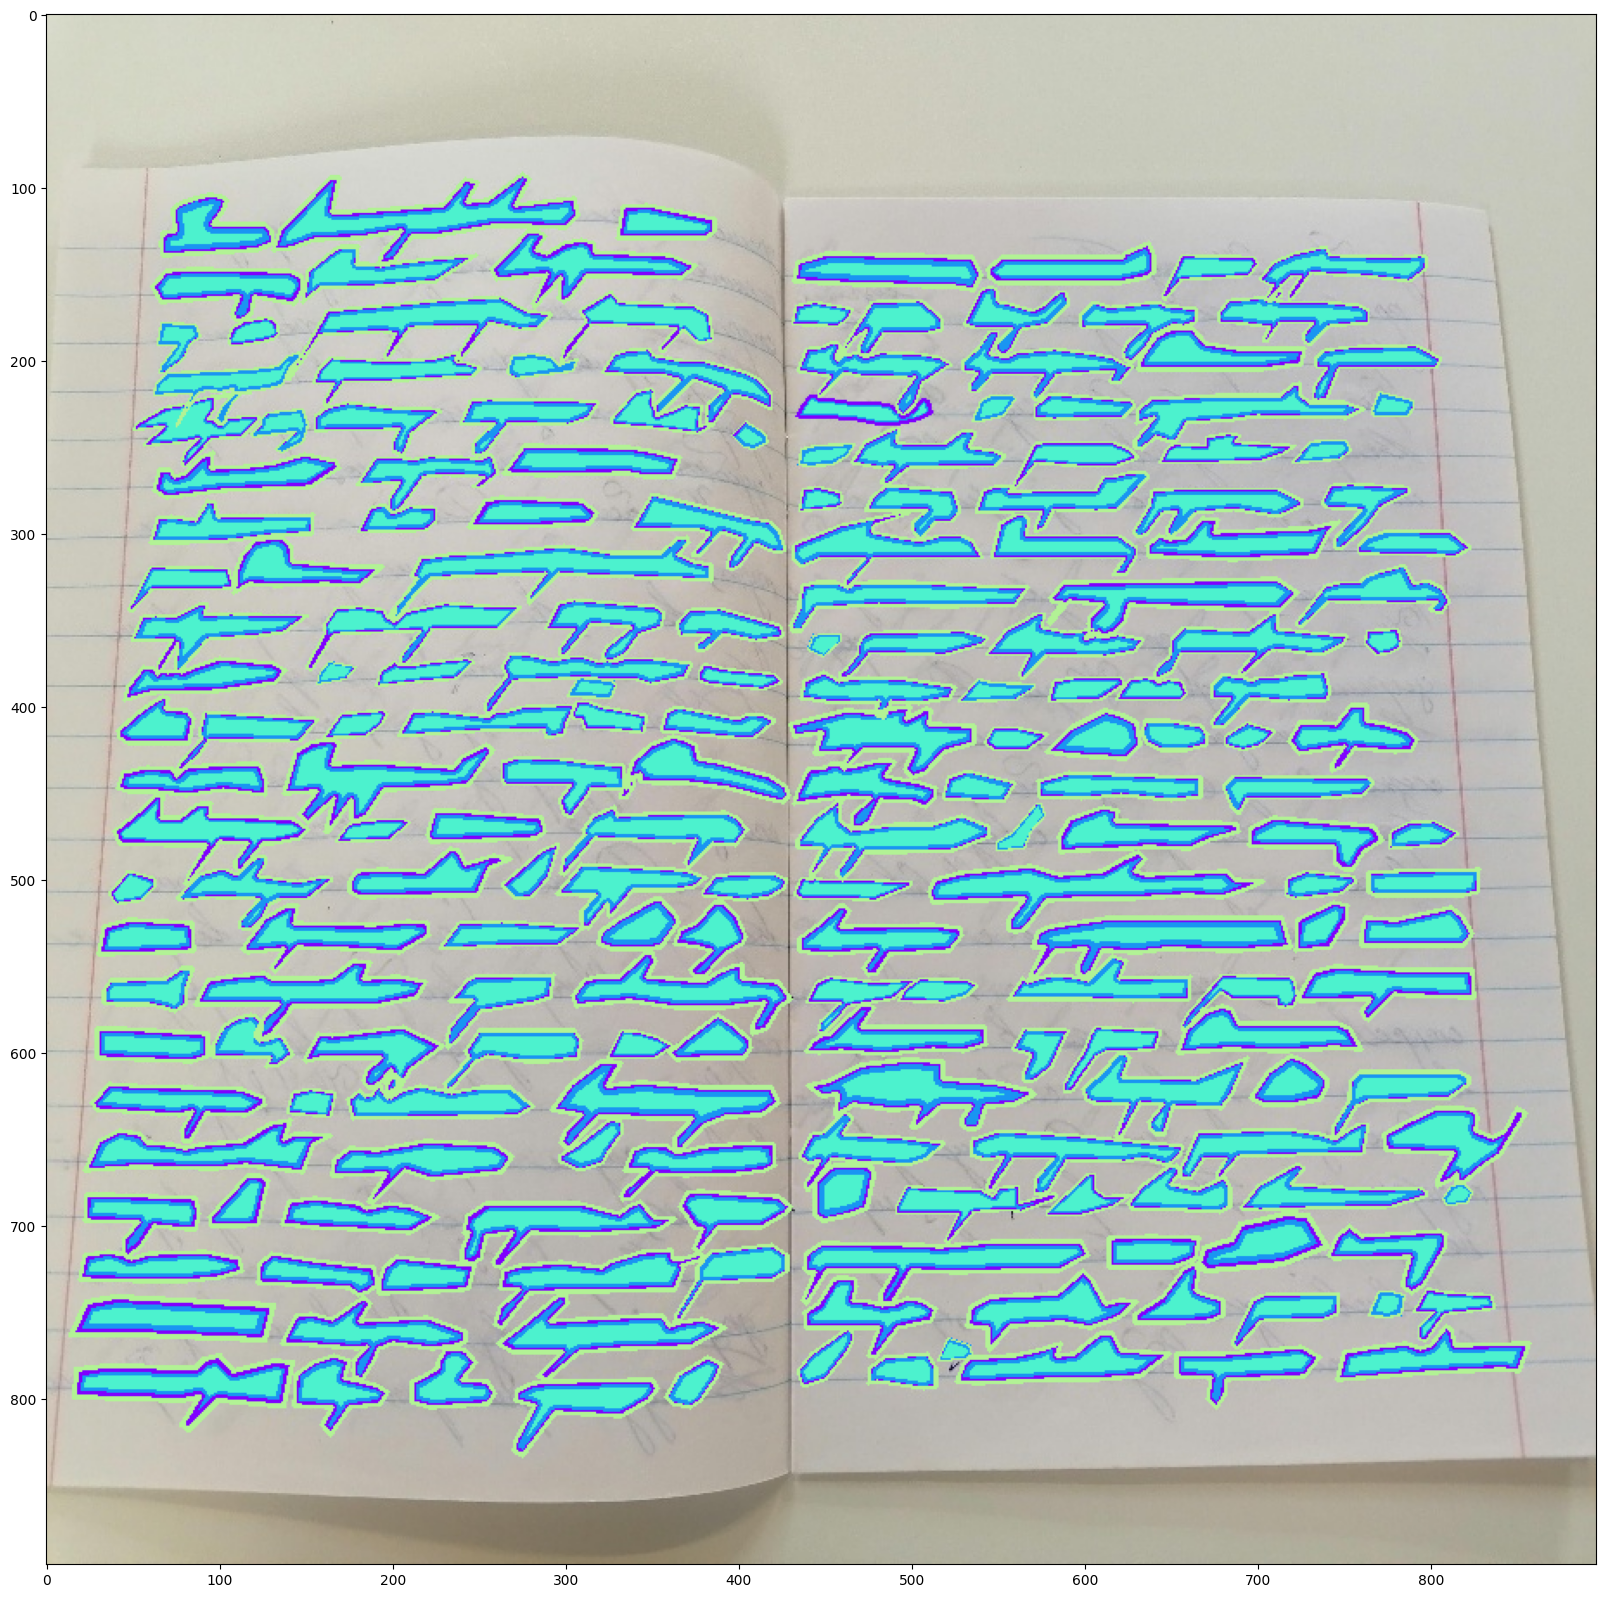

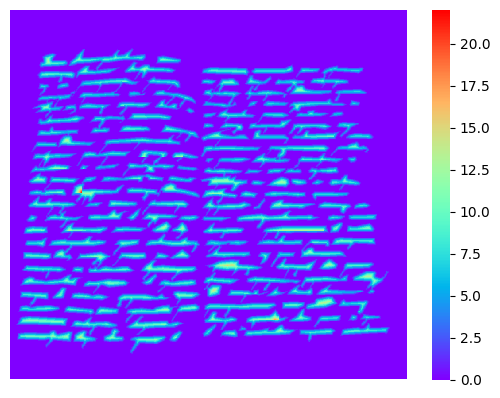

In [11]:
# iterate over 'data/raw/magazine/annotations_val.csv' less than 10 times
# plot image and corresponding mask target on the same plot for verification
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import cv2
import numpy as np
import seaborn as sns

dataset_filepath = 'data/raw/school_notebooks_RU'
csv_filename = 'annotations_test.csv'
annotations = pd.read_csv(f'{dataset_filepath}/{csv_filename}')

for i in range(len(annotations)):
    if i > 2: break

    row = annotations.iloc[i]

    image_path = f"{dataset_filepath}/{row['image']}"
    target_path = f"{dataset_filepath}/{row['target']}"

    print(f'{image_path=} {target_path=}')

    img = cv2.imread(image_path)
    if img is None: print('img is none')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = np.load(target_path)
    if np.max(mask) == 0: continue

    # Get a colormap
    cmap = matplotlib.colormaps.get_cmap('rainbow')

    plt.figure(figsize=(20, 40))

    # iterate over mask layers and plot them on the same plot
    print('layers count:', mask.shape[2])

    # Iterate over mask layers
    for j in range(mask.shape[2]):
        if j >= 4: continue

        # Generate a color from the colormap
        col = cmap(j / mask.shape[2])[:3]

        # Convert the color from RGBA to RGB
        color = tuple([int(channel * 255) for channel in col])

        print(f"layer {j} - color {color}")
        # Find where the mask is nonzero
        img[mask[:, :, j] > 0] = color

    plt.imshow(img)
    plt.savefig(f'data/processed/masks_{i}.png')
    plt.show()

    svm = sns.heatmap(mask[:, :, 4], cmap='rainbow', cbar=True, xticklabels=False, yticklabels=False)
    # save heatmap
    figure = svm.get_figure()
    figure.savefig(f'data/processed/colormap_{i}.png')

    """
    # Extract the x and y components
    x = mask[:, :, -2][0:150]
    y = mask[:, :, -1][0:150]
    print(f'{np.min(x)}-{np.max(x)} {np.min(y)}-{np.max(y)}')
    # Create a grid of coordinates
    Y, X = np.mgrid[0:x.shape[0], 0:x.shape[1]]
    # Plot the vector field
    plt.figure(figsize=(20, 40))
    plt.quiver(X, Y, x, y)
    plt.show()
    """